# Análises Simples - Dados Bancários

Este notebook contém **4 consultas simples** para análise exploratória dos dados bancários.

## Objetivo
- Entender volume e distribuição básica dos dados
- Identificar padrões simples de movimentação
- Validar qualidade dos dados
- Obter métricas básicas de negócio

In [ ]:
# Configuração inicial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta
import warnings, os
from dotenv import load_dotenv 
 
# Carregar variáveis do arquivo .env de um diretório específico
env_path = "../env_files/.env"
load_dotenv(dotenv_path=env_path)
warnings.filterwarnings('ignore')

# Database configuration - Alinhado com notebooks 01-03
DB_CONFIG = {
    'host': os.getenv("PGHOST", "localhost"),
    'port': int(os.getenv("PGPORT", "5432")),  # Converter para int
    'user': os.getenv("PGUSER", "postgres"),
    'password': os.getenv("PGPASSWORD", "postgres"),
    'database': os.getenv("PGDATABASE", "mkl_bank"),  # Target database correto
    'sslmode': os.getenv("PGSSLMODE", "require"),
    'connect_timeout': 30,
    'application_name': 'MKL-Bank-Analytics-Simple'
}

# Criar conexão
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}?sslmode={DB_CONFIG['sslmode']}&connect_timeout={DB_CONFIG['connect_timeout']}&application_name={DB_CONFIG['application_name']}"
engine = create_engine(connection_string)

# Schema alvo correto
TARGET_SCHEMA = os.getenv("TARGETSCHEMA", "core_bank")  # Schema correto

print("✅ Configuração concluída!")
print(f"🔗 Conectado ao banco: {DB_CONFIG['database']}")
print(f"📊 Schema: {TARGET_SCHEMA}")

✅ Configuração concluída!
🔗 Conectado ao banco: fsi_db
📊 Schema: mkl_bank


## 📊 Consulta 1: Resumo Geral dos Dados

**Objetivo**: Obter uma visão geral do volume de dados em cada tabela principal.

📋 RESUMO GERAL DOS DADOS
Cartões        :    5,609 registros
Contas         :    1,258 registros
Clientes       :    1,000 registros
Chaves PIX     :      898 registros
Agências       :      166 registros


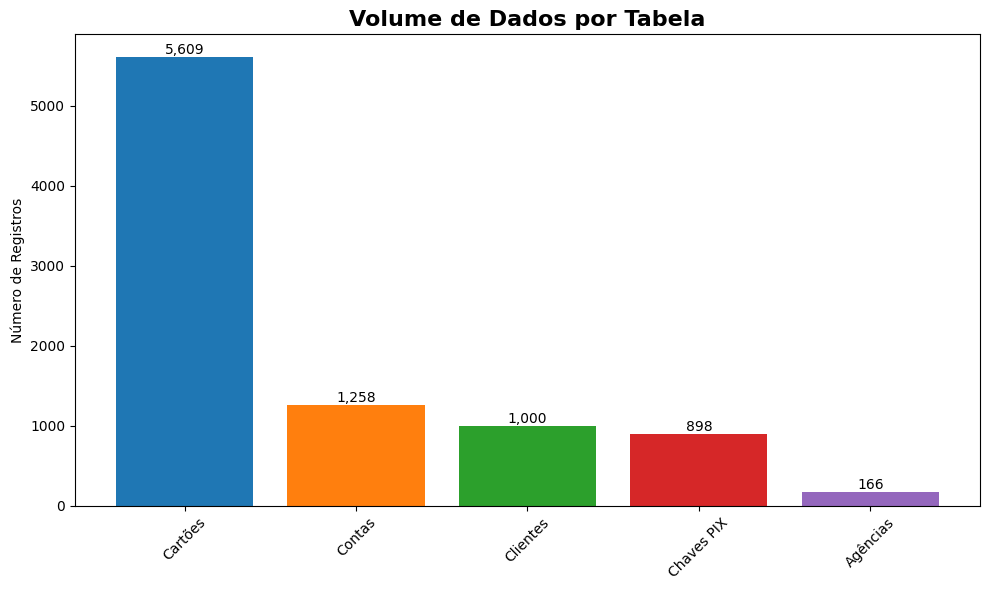

In [ ]:
# Consulta 1: Resumo geral dos dados
query_1 = f"""
SELECT 
    'Agências' as tabela,
    COUNT(*) as total_registros
FROM "{TARGET_SCHEMA}".agencias

UNION ALL

SELECT 
    'Clientes' as tabela,
    COUNT(*) as total_registros
FROM "{TARGET_SCHEMA}".clientes

UNION ALL

SELECT 
    'Contas' as tabela,
    COUNT(*) as total_registros
FROM "{TARGET_SCHEMA}".contas

UNION ALL

SELECT 
    'Cartões' as tabela,
    COUNT(*) as total_registros
FROM "{TARGET_SCHEMA}".cartoes

UNION ALL

SELECT 
    'Chaves PIX' as tabela,
    COUNT(*) as total_registros
FROM "{TARGET_SCHEMA}".chaves_pix

ORDER BY total_registros DESC;
"""

resultado_1 = pd.read_sql(query_1, engine)
print("📋 RESUMO GERAL DOS DADOS")
print("=" * 30)
for _, row in resultado_1.iterrows():
    print(f"{row['tabela']:<15}: {row['total_registros']:>8,} registros")

# Visualização
plt.figure(figsize=(10, 6))
bars = plt.bar(resultado_1['tabela'], resultado_1['total_registros'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Volume de Dados por Tabela', fontsize=16, fontweight='bold')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 💰 Consulta 2: Top 10 Movimentações por Valor

**Objetivo**: Identificar as maiores movimentações financeiras do sistema.

In [ ]:
# Primeiro, vamos verificar a estrutura da tabela transacoes
query_estrutura = f"""
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_schema = '{TARGET_SCHEMA}' 
AND table_name = 'transacoes'
ORDER BY ordinal_position;
"""

estrutura = pd.read_sql(query_estrutura, engine)
print("🔍 ESTRUTURA DA TABELA TRANSACOES")
print("=" * 40)
for _, row in estrutura.iterrows():
    print(f"{row['column_name']:<20}: {row['data_type']}")

# Vamos também ver alguns dados de exemplo
query_exemplo = f"""
SELECT * FROM "{TARGET_SCHEMA}".transacoes 
LIMIT 5;
"""

exemplo = pd.read_sql(query_exemplo, engine)
print("\n📋 DADOS DE EXEMPLO:")
print(exemplo)

🔍 ESTRUTURA DA TABELA TRANSACAO_CONTA
id_transacao        : character varying
id_conta            : integer
data_transacao      : timestamp without time zone
valor               : numeric
tipo                : character
descricao           : character varying

📋 DADOS DE EXEMPLO:
                 id_transacao  id_conta      data_transacao     valor tipo  \
0  01050145240015669831979203       458 2024-01-01 05:45:00  65434.03    C   
1  01120148241104867493468074      1095 2024-01-01 12:48:11  63778.18    C   
2  01000154240222183622592252       926 2024-01-01 00:54:02  80253.20    D   
3  01090110241364043763158609       669 2024-01-01 09:10:13  66993.66    D   
4  01030137243250412290397691        72 2024-01-01 03:37:32  59290.06    D   

                                    descricao  
0  Transação C - Conta 79138-9 - Agência 6651  
1  Transação C - Conta 64394-7 - Agência 6840  
2  Transação D - Conta 95226-3 - Agência 8122  
3  Transação D - Conta 51367-3 - Agência 4046  
4  Transaç

💰 TOP 10 MOVIMENTAÇÕES POR VALOR
 1. R$    99,997.27 | D    | 25/01/2024 11:48
 2. R$    99,981.66 | D    | 16/04/2024 13:35
 3. R$    99,972.21 | D    | 10/01/2024 20:11
 4. R$    99,972.00 | D    | 07/05/2024 04:38
 5. R$    99,971.82 | C    | 12/02/2024 13:04
 6. R$    99,960.53 | D    | 08/03/2024 17:27
 7. R$    99,959.94 | D    | 05/02/2024 23:42
 8. R$    99,955.41 | C    | 08/05/2024 14:51
 9. R$    99,950.59 | C    | 08/04/2024 13:25
10. R$    99,949.39 | C    | 06/01/2024 08:04


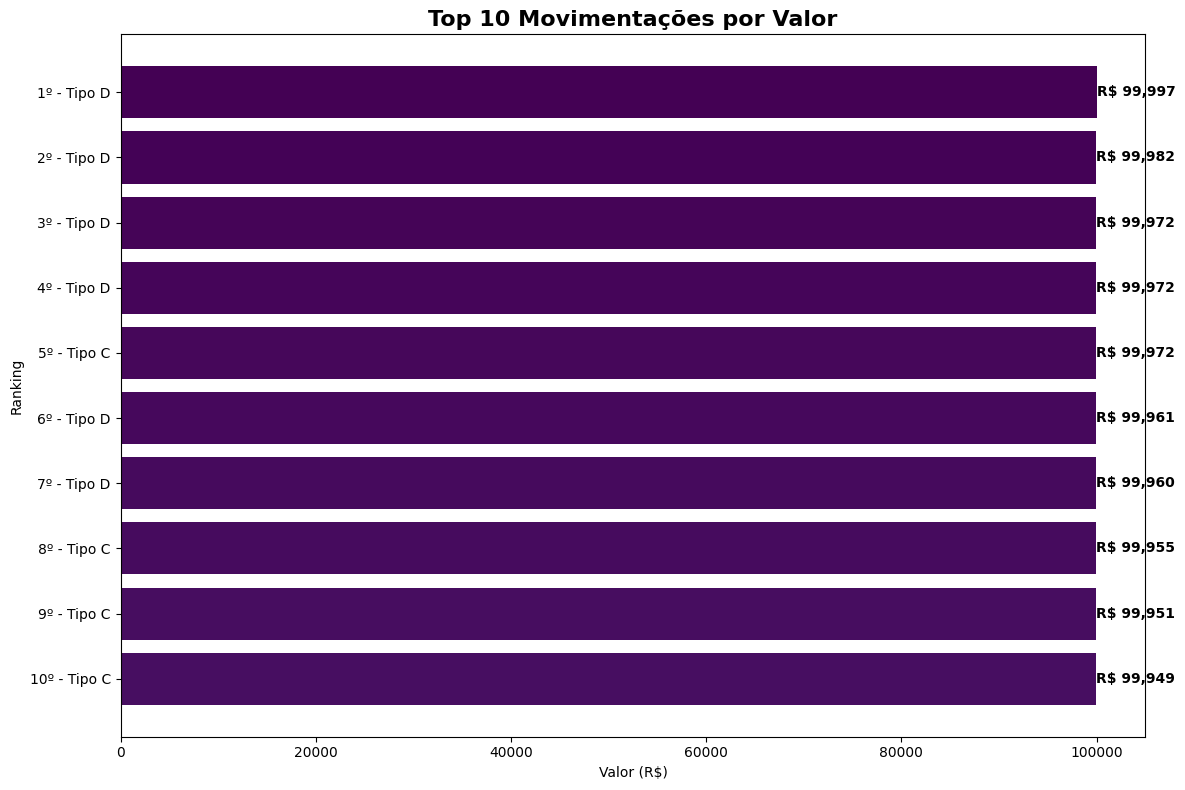

In [ ]:
# Consulta 2: Top 10 movimentações por valor
query_2 = f"""
SELECT 
    id_transacao,
    data_transacao,
    valor,
    tipo,
    descricao
FROM "{TARGET_SCHEMA}".transacoes
ORDER BY valor DESC
LIMIT 10;
"""

resultado_2 = pd.read_sql(query_2, engine)
print("💰 TOP 10 MOVIMENTAÇÕES POR VALOR")
print("=" * 50)

for i, row in resultado_2.iterrows():
    print(f"{i+1:2d}. R$ {row['valor']:>12,.2f} | {row['tipo']:<4} | {row['data_transacao'].strftime('%d/%m/%Y %H:%M')}")

# Visualização
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(range(len(resultado_2)))
bars = plt.barh(range(len(resultado_2)), resultado_2['valor'], color=colors)

plt.title('Top 10 Movimentações por Valor', fontsize=16, fontweight='bold')
plt.xlabel('Valor (R$)')
plt.ylabel('Ranking')

# Configurar labels do eixo Y
plt.yticks(range(len(resultado_2)), 
           [f"{i+1}º - Tipo {row['tipo']}" for i, (_, row) in enumerate(resultado_2.iterrows())])

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2.,
             f'R$ {width:,.0f}',
             ha='left', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 📅 Consulta 3: Distribuição de Movimentações por Mês

**Objetivo**: Analisar o volume de transações ao longo dos meses.

📅 DISTRIBUIÇÃO MENSAL DE MOVIMENTAÇÕES
Mês      Transações   Valor Total     Valor Médio 
-------------------------------------------------------
01/2024      3,132    159,163,200      50,818
02/2024      3,202    161,112,696      50,316
03/2024      3,432    171,937,102      50,098
04/2024      3,485    174,170,416      49,977
05/2024      1,690     82,991,004      49,107


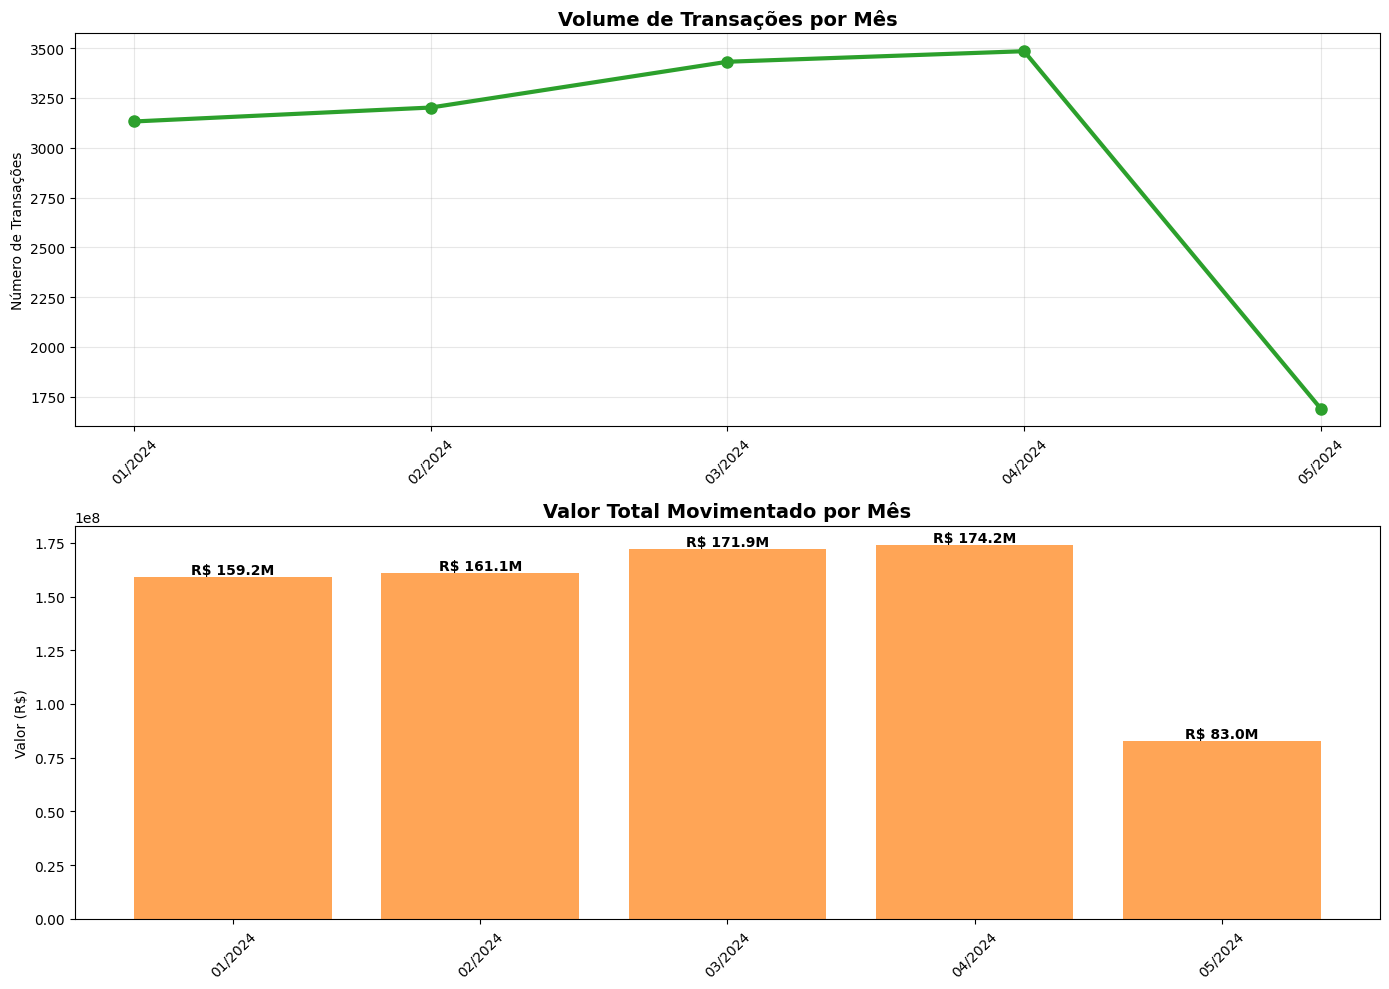

In [ ]:
# Consulta 3: Distribuição de movimentações por mês
query_3 = f"""
SELECT 
    DATE_TRUNC('month', data_transacao) as mes,
    COUNT(*) as total_transacoes,
    SUM(valor) as valor_total,
    AVG(valor) as valor_medio
FROM "{TARGET_SCHEMA}".transacoes
GROUP BY DATE_TRUNC('month', data_transacao)
ORDER BY mes;
"""

resultado_3 = pd.read_sql(query_3, engine)
resultado_3['mes'] = pd.to_datetime(resultado_3['mes'])
resultado_3['mes_str'] = resultado_3['mes'].dt.strftime('%m/%Y')

print("📅 DISTRIBUIÇÃO MENSAL DE MOVIMENTAÇÕES")
print("=" * 55)
print(f"{'Mês':<8} {'Transações':<12} {'Valor Total':<15} {'Valor Médio':<12}")
print("-" * 55)

for _, row in resultado_3.iterrows():
    print(f"{row['mes_str']:<8} {row['total_transacoes']:>9,} {row['valor_total']:>14,.0f} {row['valor_medio']:>11,.0f}")

# Visualização
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Volume de transações
ax1.plot(resultado_3['mes_str'], resultado_3['total_transacoes'], 
         marker='o', linewidth=3, markersize=8, color='#2ca02c')
ax1.set_title('Volume de Transações por Mês', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Transações')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Valor total movimentado
bars = ax2.bar(resultado_3['mes_str'], resultado_3['valor_total'], 
               color='#ff7f0e', alpha=0.7)
ax2.set_title('Valor Total Movimentado por Mês', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valor (R$)')
ax2.tick_params(axis='x', rotation=45)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'R$ {height/1e6:.1f}M',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 🏆 Consulta 4: Estatísticas de Chaves PIX por Tipo

**Objetivo**: Analisar a distribuição e uso das diferentes tipos de chaves PIX.

🏆 ESTATÍSTICAS DE CHAVES PIX POR TIPO
Tipo         Total    Ativas   Inativas   % Ativas  
------------------------------------------------------------
telefone        245    113      132     46.1%
email           238    120      118     50.4%
cpf             212    100      112     47.2%
aleatoria       203    122       81     60.1%


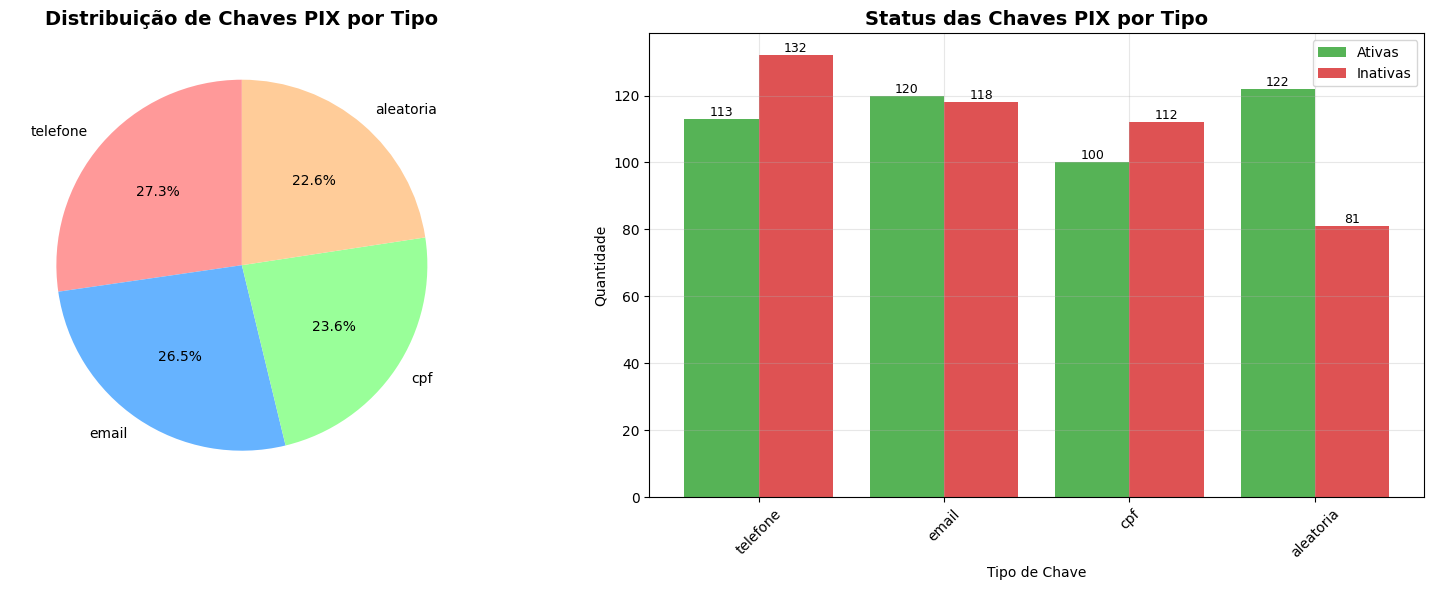


✅ Análises simples concluídas!
📊 Próximo passo: Execute o notebook de análises intermediárias


In [ ]:
# Consulta 4: Estatísticas de chaves PIX por tipo
query_4 = f"""
SELECT 
    tipo_chave,
    COUNT(*) as total_chaves,
    COUNT(CASE WHEN status = 'A' THEN 1 END) as chaves_ativas,
    COUNT(CASE WHEN status = 'I' THEN 1 END) as chaves_inativas,
    ROUND(
        (COUNT(CASE WHEN status = 'A' THEN 1 END) * 100.0 / COUNT(*)), 2
    ) as percentual_ativas
FROM "{TARGET_SCHEMA}".chaves_pix
GROUP BY tipo_chave
ORDER BY total_chaves DESC;
"""

resultado_4 = pd.read_sql(query_4, engine)

print("🏆 ESTATÍSTICAS DE CHAVES PIX POR TIPO")
print("=" * 60)
print(f"{'Tipo':<12} {'Total':<8} {'Ativas':<8} {'Inativas':<10} {'% Ativas':<10}")
print("-" * 60)

for _, row in resultado_4.iterrows():
    print(f"{row['tipo_chave']:<12} {row['total_chaves']:>6,} {row['chaves_ativas']:>6,} {row['chaves_inativas']:>8,} {row['percentual_ativas']:>8.1f}%")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Distribuição por tipo
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
wedges, texts, autotexts = ax1.pie(resultado_4['total_chaves'], 
                                   labels=resultado_4['tipo_chave'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax1.set_title('Distribuição de Chaves PIX por Tipo', fontsize=14, fontweight='bold')

# Gráfico 2: Status das chaves
tipos = resultado_4['tipo_chave']
x_pos = range(len(tipos))

bars1 = ax2.bar([x - 0.2 for x in x_pos], resultado_4['chaves_ativas'], 
                width=0.4, label='Ativas', color='#2ca02c', alpha=0.8)
bars2 = ax2.bar([x + 0.2 for x in x_pos], resultado_4['chaves_inativas'], 
                width=0.4, label='Inativas', color='#d62728', alpha=0.8)

ax2.set_title('Status das Chaves PIX por Tipo', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tipo de Chave')
ax2.set_ylabel('Quantidade')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(tipos, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Análises simples concluídas!")
print("📊 Próximo passo: Execute o notebook de análises intermediárias")